In [21]:
from __future__ import print_function
import random
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import time
import math
from scipy import linalg
from game import Board, Game
from mcts_alphaZero import MCTSPlayer
from policy_value_net_tensorflow import PolicyValueNet 
from pretrain import pretraind


def runqzero(sample,case,pptrain,exploration,game_batch_num,lr,ini):
    
    class TrainPipeline():
        def __init__(self, init_model=None):
            time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))

            # params of the board and the game
            self.board_width = 20      #N-qubit    divide
            self.board_height = 5    # N-modular     frequency

            self.Mheight=21         #M-clause
            self.Nwidth=7        #N-qubit
            self.Nqubit=self.Nwidth
            self.T=70

            print("sample",sample,"case",case)
            #resultcc=np.loadtxt('sat'+str(self.Nqubit)+'-result1.txt')       #training data
            resultcc=np.loadtxt('sat'+str(self.Nqubit)+'-result2.txt')      #test data
            resultc1=resultcc.tolist()
            print("result",len(resultc1))
            result=[int(x) for x in resultc1[sample]]  #pretrain data
        
            #hh=np.loadtxt('sat'+str(self.Nqubit)+'-info1.txt')   
            hh=np.loadtxt('sat'+str(self.Nqubit)+'-info2.txt')  
            Hinfo=hh.tolist()
            print("Hinfo",len(Hinfo))
            Hi=Hinfo[sample]
                  
            
            print("ini",ini)
            self.board = Board(ini,self.T,self.Nqubit,result,Hi,height=self.board_height,width=self.board_width,Mheight=self.Mheight,Nwidth=self.Nwidth)
            self.game = Game(self.board)

            # training params
            self.n_playout =10  # num of simulations for each move                             ~~~~~~~~~~~~~~~~~~~~~~~~修改8.26
            self.game_batch_num = game_batch_num
            self.batch_size = 20 # mini-batch size for training

            self.learn_rate =lr
            self.lr_multiplier = 1.0  # adaptively adjust the learning rate based on KL
            self.temp = 1.0  # the temperature param
            self.c_puct =3  #explore



            self.buffer_size = 10000
            self.data_buffer = deque(maxlen=self.buffer_size)
            self.play_batch_size = 1
            self.epochs = 50  # num of train_steps for each update
            self.kl_targ = 0.02

            self.lossvalue=[]
            self.entropyvalue=[]
            self.energy=[]
            self.fidelity=[]
            self.step=0


            if init_model:
                print("init_model1",init_model)
                # start training from an initial policy-value net
                self.policy_value_net = PolicyValueNet(self.board_height,self.board_width,self.Mheight,self.Nwidth,model_file=init_model)
            else:
                print("init_model",init_model)
                # start training from a new policy-value net
                self.policy_value_net = PolicyValueNet(self.board_height,self.board_width,self.Mheight,self.Nwidth)




        def collect_selfplay_data(self, n_games=1,cc_puct=2,plore=1):

            self.mcts_player = MCTSPlayer(self.policy_value_net.policy_value_fn,c_puct=cc_puct,n_playout=self.n_playout,is_selfplay=plore)

            for i in range(n_games):

                winner, play_data, energy,overlap = self.game.start_self_play(self.mcts_player,temp=self.temp)

                self.energy.append(energy)
                self.fidelity.append(overlap)
                play_data = list(play_data)[:] 
                self.episode_len = len(play_data)
                self.data_buffer.extend(play_data)     



        def policy_update(self):
            """update the policy-value net"""

            mini_batch = random.sample(self.data_buffer, self.batch_size)

            
            good_batch=[]
            for da in self.data_buffer:
                if da[2]==10:
                    good_batch.append(da)
      
            train_batch=mini_batch+good_batch
            
            state_batch = [data[0] for data in train_batch]
            mcts_probs_batch = [data[1] for data in train_batch]
            winner_batch = [data[2] for data in train_batch]
            
            print("train_length:",len(train_batch))

            old_probs, old_v = self.policy_value_net.policy_value(state_batch)
            for i in range(self.epochs):
                loss, entropy = self.policy_value_net.train_step(state_batch,mcts_probs_batch,winner_batch,self.learn_rate*self.lr_multiplier)


                new_probs, new_v = self.policy_value_net.policy_value(state_batch)
                kl = np.mean(np.sum(old_probs * (np.log(old_probs + 1e-10) - np.log(new_probs + 1e-10)),axis=1) )            

            if self.step>150:
                self.lr_multiplier=0.5            
            if self.step>300:
                self.lr_multiplier=0.3
                self.batch_size=60
            if self.step>400:
                self.lr_multiplier=0.1
                self.batch_size=100




            self.lossvalue.append(loss)
            self.entropyvalue.append(entropy)
            print(("kl:{:.5f},""lr_multiplier:{:.3f},""loss:{},""entropy:{}").format(kl,self.lr_multiplier,loss,entropy))
            return loss, entropy



        def run(self):     

            for i in range(self.game_batch_num):   
                self.step=self.step+1
                self.collect_selfplay_data(self.play_batch_size,5,0)

                print("batch i:{}, episode_len:{}".format(i+1, self.episode_len))
                print("~~~~~~~~~~~~~~~~~~~~~~")
                
                if len(self.data_buffer) > self.batch_size:
                    loss, entropy = self.policy_update()






        def run2(self):     

            for i in range(int(self.game_batch_num/2)):   
                self.step=self.step+1
                self.collect_selfplay_data(self.play_batch_size,0.5,0)

                print("batch i:{}, episode_len:{}".format(i+1, self.episode_len))
                print("~~~~~~~~~~~~~~~~~~~~~~")

                if len(self.data_buffer) > self.batch_size:
                    loss, entropy = self.policy_update()




        def run1(self):     


                plt.plot(self.energy,label="energy")
                plt.ylim(0,1)
                plt.legend()
                plt.show()
                plt.plot(self.fidelity,label="fidelity")
                plt.ylim(0,1)
                plt.legend()
                
                
                filename='qzerop'+"s"+str(sample)+"c"+str(case)
                np.savetxt(filename+'fidelity.txt', np.array(self.fidelity))
                plt.savefig(filename+'fidelity.jpg')
                plt.show()



        def prerun(self):   

            learn_rate= 2e-3
            lr_multiplier= 1.0
            epochs=200

            fgood='sat'+str(self.Nqubit)+"-"+str(self.T)+'train.txt'
            finfo='sat'+str(self.Nqubit)+'-info1.txt'
            
            state_batch2,mcts_probs_batch,winner_batch=pretraind.pretraindata(fgood,finfo)


            lossvalue=[]
            entropyvalue=[]
            for i in range(epochs):
                loss, entropy = self.policy_value_net.train_step(state_batch2,mcts_probs_batch,winner_batch,learn_rate*lr_multiplier)   #batch1,batch2
                lossvalue.append(loss)
                entropyvalue.append(entropy)


            plt.plot(lossvalue) 
            plt.show()
            





    if __name__ == '__main__':


        training_pipeline = TrainPipeline()
        
    if pptrain==1:
        training_pipeline.prerun()

    if exploration==1:
        training_pipeline.run()    #strong explore
    training_pipeline.run2()   #weak explore

    
    training_pipeline.run1()  #plot
    

sample 6 case 2
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
Hinfo 199
totoalinput_dim 247


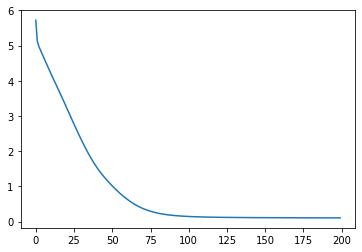

 c_puct 5
movelist-end [10, 30, 49, 71, 88] fail
obs: [ 0.    0.   -0.02  0.02 -0.04]
movelist-end [10, 30, 49, 71, 90] fail
obs: [ 0.    0.   -0.02  0.02  0.  ]
movelist-end [10, 30, 49, 71, 88] fail
obs: [ 0.    0.   -0.02  0.02 -0.04]
move 10
movelist-end [10, 36, 49, 71, 88] fail
obs: [ 0.    0.12 -0.02  0.02 -0.04]
movelist-end [10, 36, 49, 71, 88] fail
obs: [ 0.    0.12 -0.02  0.02 -0.04]
movelist-end [10, 36, 49, 71, 88] fail
obs: [ 0.    0.12 -0.02  0.02 -0.04]
movelist-end [10, 37, 49, 71, 88] fail
obs: [ 0.    0.14 -0.02  0.02 -0.04]
movelist-end [10, 37, 49, 71, 88] fail
obs: [ 0.    0.14 -0.02  0.02 -0.04]
movelist-end [10, 37, 49, 71, 88] fail
obs: [ 0.    0.14 -0.02  0.02 -0.04]
move 36
movelist-end [10, 36, 49, 71, 88] fail
obs: [ 0.    0.12 -0.02  0.02 -0.04]
movelist-end [10, 36, 49, 71, 88] fail
obs: [ 0.    0.12 -0.02  0.02 -0.04]
movelist-end [10, 36, 49, 71, 88] fail
obs: [ 0.    0.12 -0.02  0.02 -0.04]
movelist-end [10, 36, 49, 68, 88] fail
obs: [ 0.    0.12 -0.02

movelist-end [10, 37, 49, 71, 88] fail
obs: [ 0.    0.14 -0.02  0.02 -0.04]
move 68
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
movelist-end [10, 37, 49, 68, 89] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.02]
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
move 88
movelist-end [10, 37, 49, 68, 88] fail
obs: [ 0.    0.14 -0.02 -0.04 -0.04]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:4, episode_len:5


movelist-end [13, 37, 59, 71, 93] fail
obs: [0.06 0.14 0.18 0.02 0.06]
movelist-end [13, 37, 59, 71, 91] fail
obs: [0.06 0.14 0.18 0.02 0.02]
movelist-end [13, 37, 59, 71, 92] fail
obs: [0.06 0.14 0.18 0.02 0.04]
movelist-end [13, 37, 59, 71, 83] fail
obs: [ 0.06  0.14  0.18  0.02 -0.14]
movelist-end [13, 37, 59, 71, 98] fail
obs: [0.06 0.14 0.18 0.02 0.16]
move 83
movelist-end [13, 37, 59, 71, 83] fail
obs: [ 0.06  0.14  0.18  0.02 -0.14]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:9, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 24
kl:0.17803,lr_multiplier:1.000,loss:28.84232521057129,entropy:2.6537230014801025
 c_puct 5
move 19
move 37
move 49
movelist-end [19, 37, 49, 71, 88] fail
obs: [ 0.18  0.14 -0.02  0.02 -0.04]
movelist-end [19, 37, 49, 71, 90] fail
obs: [ 0.18  0.14 -0.02  0.02  0.  ]
move 71
movelist-end [19, 37, 49, 71, 87] fail
obs: [ 0.18  0.14 -0.02  0.02 -0.06]
movelist-end [19, 37, 49, 71, 91] fail
obs: [ 0.18  0.14 -0.02  0.02  0.02]
movelist-end [19,

move 42
move 71
movelist-end [13, 30, 42, 71, 88] fail
obs: [ 0.06  0.   -0.16  0.02 -0.04]
movelist-end [13, 30, 42, 71, 92] fail
obs: [ 0.06  0.   -0.16  0.02  0.04]
movelist-end [13, 30, 42, 71, 90] fail
obs: [ 0.06  0.   -0.16  0.02  0.  ]
movelist-end [13, 30, 42, 71, 91] fail
obs: [ 0.06  0.   -0.16  0.02  0.02]
movelist-end [13, 30, 42, 71, 89] fail
obs: [ 0.06  0.   -0.16  0.02 -0.02]
movelist-end [13, 30, 42, 71, 96] fail
obs: [ 0.06  0.   -0.16  0.02  0.12]
movelist-end [13, 30, 42, 71, 93] fail
obs: [ 0.06  0.   -0.16  0.02  0.06]
movelist-end [13, 30, 42, 71, 87] fail
obs: [ 0.06  0.   -0.16  0.02 -0.06]
movelist-end [13, 30, 42, 71, 83] fail
obs: [ 0.06  0.   -0.16  0.02 -0.14]
movelist-end [13, 30, 42, 71, 98] fail
obs: [ 0.06  0.   -0.16  0.02  0.16]
move 90
movelist-end [13, 30, 42, 71, 90] fail
obs: [ 0.06  0.   -0.16  0.02  0.  ]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:17, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 29
kl:0.17558,lr_multiplier:1.

movelist-end [10, 36, 50, 70, 88] fail
obs: [ 0.    0.12  0.    0.   -0.04]
movelist-end [10, 36, 59, 71, 88] fail
obs: [ 0.    0.12  0.18  0.02 -0.04]
move 49
movelist-end [10, 36, 49, 69, 88] fail
obs: [ 0.    0.12 -0.02 -0.02 -0.04]
movelist-end [10, 36, 49, 67, 88] fail
obs: [ 0.    0.12 -0.02 -0.06 -0.04]
movelist-end [10, 36, 49, 68, 88] fail
obs: [ 0.    0.12 -0.02 -0.04 -0.04]
movelist-end [10, 36, 49, 71, 92] fail
obs: [ 0.    0.12 -0.02  0.02  0.04]
movelist-end [10, 36, 49, 62, 88] fail
obs: [ 0.    0.12 -0.02 -0.16 -0.04]
move 62
movelist-end [10, 36, 49, 62, 92] fail
obs: [ 0.    0.12 -0.02 -0.16  0.04]
movelist-end [10, 36, 49, 62, 90] fail
obs: [ 0.    0.12 -0.02 -0.16  0.  ]
movelist-end [10, 36, 49, 62, 91] fail
obs: [ 0.    0.12 -0.02 -0.16  0.02]
movelist-end [10, 36, 49, 62, 87] fail
obs: [ 0.    0.12 -0.02 -0.16 -0.06]
movelist-end [10, 36, 49, 62, 89] fail
obs: [ 0.    0.12 -0.02 -0.16 -0.02]
movelist-end [10, 36, 49, 62, 93] fail
obs: [ 0.    0.12 -0.02 -0.16  0.

movelist-end [10, 30, 42, 71, 92] fail
obs: [ 0.    0.   -0.16  0.02  0.04]
movelist-end [10, 30, 51, 71, 88] fail
obs: [ 0.    0.    0.02  0.02 -0.04]
movelist-end [10, 30, 51, 71, 92] fail
obs: [0.   0.   0.02 0.02 0.04]
move 51
movelist-end [10, 30, 51, 68, 88] fail
obs: [ 0.    0.    0.02 -0.04 -0.04]
movelist-end [10, 30, 51, 70, 88] fail
obs: [ 0.    0.    0.02  0.   -0.04]
movelist-end [10, 30, 51, 62, 88] fail
obs: [ 0.    0.    0.02 -0.16 -0.04]
movelist-end [10, 30, 51, 66, 88] fail
obs: [ 0.    0.    0.02 -0.08 -0.04]
movelist-end [10, 30, 51, 60, 88] fail
obs: [ 0.    0.    0.02 -0.2  -0.04]
move 62
movelist-end [10, 30, 51, 62, 92] fail
obs: [ 0.    0.    0.02 -0.16  0.04]
movelist-end [10, 30, 51, 62, 90] fail
obs: [ 0.    0.    0.02 -0.16  0.  ]
movelist-end [10, 30, 51, 62, 91] fail
obs: [ 0.    0.    0.02 -0.16  0.02]
movelist-end [10, 30, 51, 62, 89] fail
obs: [ 0.    0.    0.02 -0.16 -0.02]
movelist-end [10, 30, 51, 62, 96] fail
obs: [ 0.    0.    0.02 -0.16  0.12]
m

kl:0.22655,lr_multiplier:1.000,loss:42.75914764404297,entropy:3.3484809398651123
 c_puct 0.5
movelist-end [10, 30, 50, 71, 92] fail
obs: [0.   0.   0.   0.02 0.04]
movelist-end [10, 30, 50, 71, 90] fail
obs: [0.   0.   0.   0.02 0.  ]
movelist-end [10, 30, 49, 71, 92] fail
obs: [ 0.    0.   -0.02  0.02  0.04]
move 10
movelist-end [10, 30, 49, 71, 90] fail
obs: [ 0.    0.   -0.02  0.02  0.  ]
movelist-end [10, 30, 47, 71, 92] fail
obs: [ 0.    0.   -0.06  0.02  0.04]
movelist-end [10, 30, 47, 71, 90] fail
obs: [ 0.    0.   -0.06  0.02  0.  ]
movelist-end [10, 30, 42, 71, 92] fail
obs: [ 0.    0.   -0.16  0.02  0.04]
movelist-end [10, 30, 42, 71, 90] fail
obs: [ 0.    0.   -0.16  0.02  0.  ]
move 30
movelist-end [10, 30, 51, 71, 92] fail
obs: [0.   0.   0.02 0.02 0.04]
movelist-end [10, 30, 51, 71, 90] fail
obs: [0.   0.   0.02 0.02 0.  ]
movelist-end [10, 30, 59, 71, 92] fail
obs: [0.   0.   0.18 0.02 0.04]
movelist-end [10, 30, 59, 71, 90] fail
obs: [0.   0.   0.18 0.02 0.  ]
movelist-

movelist-end [10, 30, 58, 71, 88] fail
obs: [ 0.    0.    0.16  0.02 -0.04]
move 47
movelist-end [10, 30, 47, 70, 88] fail
obs: [ 0.    0.   -0.06  0.   -0.04]
movelist-end [10, 30, 47, 68, 88] fail
obs: [ 0.    0.   -0.06 -0.04 -0.04]
movelist-end [10, 30, 47, 66, 88] fail
obs: [ 0.    0.   -0.06 -0.08 -0.04]
movelist-end [10, 30, 47, 67, 88] fail
obs: [ 0.    0.   -0.06 -0.06 -0.04]
movelist-end [10, 30, 47, 69, 88] fail
obs: [ 0.    0.   -0.06 -0.02 -0.04]
move 71
movelist-end [10, 30, 47, 71, 90] fail
obs: [ 0.    0.   -0.06  0.02  0.  ]
movelist-end [10, 30, 47, 71, 91] fail
obs: [ 0.    0.   -0.06  0.02  0.02]
movelist-end [10, 30, 47, 71, 89] fail
obs: [ 0.    0.   -0.06  0.02 -0.02]
movelist-end [10, 30, 47, 71, 87] fail
obs: [ 0.    0.   -0.06  0.02 -0.06]
movelist-end [10, 30, 47, 71, 98] fail
obs: [ 0.    0.   -0.06  0.02  0.16]
movelist-end [10, 30, 47, 71, 83] fail
obs: [ 0.    0.   -0.06  0.02 -0.14]
movelist-end [10, 30, 47, 71, 96] fail
obs: [ 0.    0.   -0.06  0.02  0.

kl:0.17951,lr_multiplier:1.000,loss:42.71554946899414,entropy:3.3802833557128906
 c_puct 0.5
movelist-end [10, 30, 50, 71, 92] fail
obs: [0.   0.   0.   0.02 0.04]
movelist-end [10, 30, 50, 71, 90] fail
obs: [0.   0.   0.   0.02 0.  ]
movelist-end [10, 30, 49, 71, 92] fail
obs: [ 0.    0.   -0.02  0.02  0.04]
move 10
movelist-end [10, 30, 49, 71, 90] fail
obs: [ 0.    0.   -0.02  0.02  0.  ]
movelist-end [10, 30, 57, 71, 92] fail
obs: [0.   0.   0.14 0.02 0.04]
movelist-end [10, 30, 57, 71, 90] fail
obs: [0.   0.   0.14 0.02 0.  ]
movelist-end [10, 30, 59, 71, 92] fail
obs: [0.   0.   0.18 0.02 0.04]
movelist-end [10, 30, 59, 71, 90] fail
obs: [0.   0.   0.18 0.02 0.  ]
move 30
movelist-end [10, 30, 50, 70, 92] fail
obs: [0.   0.   0.   0.   0.04]
movelist-end [10, 30, 50, 67, 92] fail
obs: [ 0.    0.    0.   -0.06  0.04]
movelist-end [10, 30, 50, 68, 92] fail
obs: [ 0.    0.    0.   -0.04  0.04]
movelist-end [10, 30, 42, 71, 92] fail
obs: [ 0.    0.   -0.16  0.02  0.04]
movelist-end [

movelist-end [10, 30, 50, 68, 90] fail
obs: [ 0.    0.    0.   -0.04  0.  ]
movelist-end [10, 30, 50, 68, 88] fail
obs: [ 0.    0.    0.   -0.04 -0.04]
movelist-end [10, 30, 50, 68, 87] fail
obs: [ 0.    0.    0.   -0.04 -0.06]
movelist-end [10, 30, 50, 68, 97] fail
obs: [ 0.    0.    0.   -0.04  0.14]
movelist-end [10, 30, 50, 68, 82] fail
obs: [ 0.    0.    0.   -0.04 -0.16]
movelist-end [10, 30, 50, 68, 98] fail
obs: [ 0.    0.    0.   -0.04  0.16]
movelist-end [10, 30, 50, 68, 83] fail
obs: [ 0.    0.    0.   -0.04 -0.14]
movelist-end [10, 30, 50, 68, 96] fail
obs: [ 0.    0.    0.   -0.04  0.12]
movelist-end [10, 30, 50, 68, 89] fail
obs: [ 0.    0.    0.   -0.04 -0.02]
move 87
movelist-end [10, 30, 50, 68, 87] fail
obs: [ 0.    0.    0.   -0.04 -0.06]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:11, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 38
kl:0.15909,lr_multiplier:1.000,loss:53.00053405761719,entropy:3.3808083534240723
 c_puct 0.5
movelist-end [10, 30, 50, 

movelist-end [10, 30, 50, 71, 92] fail
obs: [0.   0.   0.   0.02 0.04]
movelist-end [10, 30, 49, 71, 91] fail
obs: [ 0.    0.   -0.02  0.02  0.02]
move 10
movelist-end [10, 30, 49, 71, 92] fail
obs: [ 0.    0.   -0.02  0.02  0.04]
movelist-end [10, 30, 59, 71, 91] fail
obs: [0.   0.   0.18 0.02 0.02]
movelist-end [10, 30, 59, 71, 92] fail
obs: [0.   0.   0.18 0.02 0.04]
movelist-end [10, 30, 51, 71, 91] fail
obs: [0.   0.   0.02 0.02 0.02]
movelist-end [10, 30, 51, 71, 92] fail
obs: [0.   0.   0.02 0.02 0.04]
move 30
movelist-end [10, 30, 42, 71, 91] fail
obs: [ 0.    0.   -0.16  0.02  0.02]
movelist-end [10, 30, 42, 71, 92] fail
obs: [ 0.    0.   -0.16  0.02  0.04]
movelist-end [10, 30, 50, 68, 91] fail
obs: [ 0.    0.    0.   -0.04  0.02]
movelist-end [10, 30, 50, 70, 91] fail
obs: [0.   0.   0.   0.   0.02]
movelist-end [10, 30, 57, 71, 91] fail
obs: [0.   0.   0.14 0.02 0.02]
move 49
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [10, 30, 4

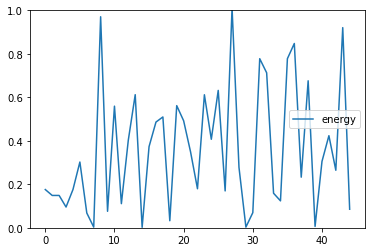

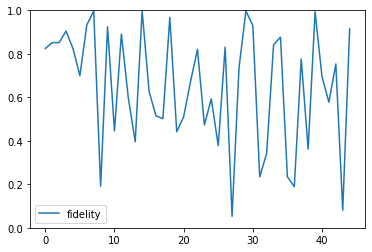

sample 6 case 3
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
Hinfo 199
totoalinput_dim 247


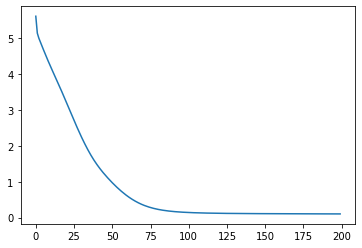

 c_puct 5
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 91] fail
obs: [ 0.04  0.   -0.02  0.    0.02]
move 10
movelist-end [10, 30, 49, 71, 91] fail
obs: [ 0.    0.   -0.02  0.02  0.02]
movelist-end [10, 30, 49, 71, 91] fail
obs: [ 0.    0.   -0.02  0.02  0.02]
movelist-end [10, 30, 51, 71, 91] fail
obs: [0.   0.   0.02 0.02 0.02]
movelist-end [10, 30, 49, 71, 91] fail
obs: [ 0.    0.   -0.02  0.02  0.02]
movelist-end [10, 30, 51, 71, 91] fail
obs: [0.   0.   0.02 0.02 0.02]
movelist-end [10, 30, 49, 71, 90] fail
obs: [ 0.    0.   -0.02  0.02  0.  ]
move 30
movelist-end [10, 30, 49, 71, 91] fail
obs: [ 0.    0.   -0.02  0.02  0.02]
movelist-end [10, 30, 51, 71, 90] fail
obs: [0.   0.   0.02 0.02 0.  ]
movelist-end [10, 30, 49, 71, 93] fail
obs: [ 0.    0.   -0.02  0.02  0.06]
movelist-end [10, 30, 52, 71, 91] fail
obs: [0.   0.   0.04 0.02 0.02]
movelist-end [10, 30, 52, 71, 91] fail
obs: [0.   0.   0.04 0.02 0.02]
movelist-en

movelist-end [12, 30, 49, 70, 91] fail
obs: [ 0.04  0.   -0.02  0.    0.02]
move 12
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 71, 91] fail
obs: [ 0.04  0.   -0.02  0.02  0.02]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 30
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 

kl:1.25146,lr_multiplier:1.000,loss:71.77603149414062,entropy:1.154231309890747
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0. 

kl:0.10456,lr_multiplier:1.000,loss:76.72235107421875,entropy:0.7725934982299805
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.03881,lr_multiplier:1.000,loss:76.30180358886719,entropy:0.5119683742523193
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.03373,lr_multiplier:1.000,loss:77.04586791992188,entropy:0.38443267345428467
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0

kl:0.03279,lr_multiplier:1.000,loss:79.2863540649414,entropy:0.25719916820526123
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.01516,lr_multiplier:1.000,loss:78.7614517211914,entropy:0.2338385134935379
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0. 

kl:0.00513,lr_multiplier:1.000,loss:79.64698028564453,entropy:0.1669890582561493
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.03423,lr_multiplier:1.000,loss:79.7743911743164,entropy:0.13249480724334717
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.00283,lr_multiplier:1.000,loss:81.00807189941406,entropy:0.107486791908741
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0

kl:0.00074,lr_multiplier:1.000,loss:81.5030517578125,entropy:0.07858048379421234
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.00338,lr_multiplier:1.000,loss:81.47026824951172,entropy:0.08582277595996857
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04 

kl:0.00114,lr_multiplier:1.000,loss:81.4234848022461,entropy:0.08197402954101562
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.00417,lr_multiplier:1.000,loss:80.55350494384766,entropy:0.0917804017663002
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

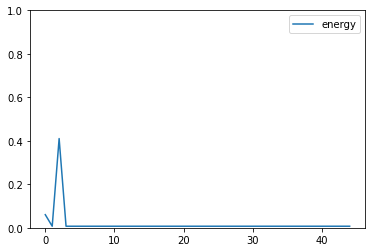

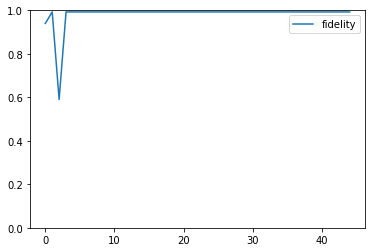

sample 6 case 4
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
Hinfo 199
totoalinput_dim 247


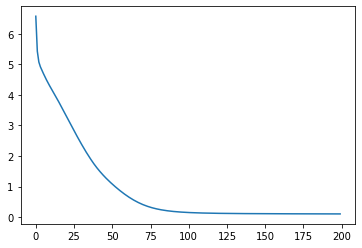

 c_puct 5
movelist-end [10, 30, 48, 68, 89] fail
obs: [ 0.    0.   -0.04 -0.04 -0.02]
move 12
movelist-end [12, 30, 48, 68, 89] fail
obs: [ 0.04  0.   -0.04 -0.04 -0.02]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 30
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 

movelist-end [10, 30, 48, 68, 91] fail
obs: [ 0.    0.   -0.04 -0.04  0.02]
movelist-end [10, 30, 48, 68, 89] fail
obs: [ 0.    0.   -0.04 -0.04 -0.02]
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [10, 30, 48, 68, 89] fail
obs: [ 0.    0.   -0.04 -0.04 -0.02]
movelist-end [10, 30, 47, 68, 89] fail
obs: [ 0.    0.   -0.06 -0.04 -0.02]
movelist-end [10, 30, 47, 68, 89] fail
obs: [ 0.    0.   -0.06 -0.04 -0.02]
movelist-end [10, 30, 48, 68, 93] fail
obs: [ 0.    0.   -0.04 -0.04  0.06]
move 49
movelist-end [10, 30, 49, 68, 88] fail
obs: [ 0.    0.   -0.02 -0.04 -0.04]
movelist-end [10, 30, 49, 68, 92] fail
obs: [ 0.    0.   -0.02 -0.04  0.04]
movelist-end [10, 30, 49, 68, 93] fail
obs: [ 0.    0.   -0.02 -0.04  0.06]
movelist-end [10, 30, 49, 68, 89] fail
obs: [ 0.    0.   -0.02 -0.04 -0.02]
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [10, 30, 49, 68, 93] fail
obs: [ 0.    0.   -0.02 -0.04  0.06]
move

kl:0.10514,lr_multiplier:1.000,loss:58.433738708496094,entropy:2.0559439659118652
 c_puct 5
movelist-end [10, 30, 49, 68, 90] fail
obs: [ 0.    0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 30
movelist-end [12, 30, 49, 68] win
o

movelist-end [10, 20, 49, 68, 89] fail
obs: [ 0.   -0.2  -0.02 -0.04 -0.02]
movelist-end [10, 20, 49, 68, 93] fail
obs: [ 0.   -0.2  -0.02 -0.04  0.06]
movelist-end [10, 20, 48, 68, 90] fail
obs: [ 0.   -0.2  -0.04 -0.04  0.  ]
movelist-end [10, 20, 48, 68, 89] fail
obs: [ 0.   -0.2  -0.04 -0.04 -0.02]
move 49
movelist-end [10, 20, 49, 70, 90] fail
obs: [ 0.   -0.2  -0.02  0.    0.  ]
movelist-end [10, 20, 49, 68, 91] fail
obs: [ 0.   -0.2  -0.02 -0.04  0.02]
movelist-end [10, 20, 49, 71, 90] fail
obs: [ 0.   -0.2  -0.02  0.02  0.  ]
movelist-end [10, 20, 49, 68, 88] fail
obs: [ 0.   -0.2  -0.02 -0.04 -0.04]
movelist-end [10, 20, 49, 70, 89] fail
obs: [ 0.   -0.2  -0.02  0.   -0.02]
movelist-end [10, 20, 49, 67, 90] fail
obs: [ 0.   -0.2  -0.02 -0.06  0.  ]
movelist-end [10, 20, 49, 61, 90] fail
obs: [ 0.   -0.2  -0.02 -0.18  0.  ]
move 61
movelist-end [10, 20, 49, 61, 89] fail
obs: [ 0.   -0.2  -0.02 -0.18 -0.02]
movelist-end [10, 20, 49, 61, 93] fail
obs: [ 0.   -0.2  -0.02 -0.18  0.

movelist-end [10, 30, 47, 68, 89] fail
obs: [ 0.    0.   -0.06 -0.04 -0.02]
movelist-end [10, 30, 47, 69, 91] fail
obs: [ 0.    0.   -0.06 -0.02  0.02]
move 71
movelist-end [10, 30, 47, 71, 90] fail
obs: [ 0.    0.   -0.06  0.02  0.  ]
movelist-end [10, 30, 47, 71, 93] fail
obs: [ 0.    0.   -0.06  0.02  0.06]
movelist-end [10, 30, 47, 71, 89] fail
obs: [ 0.    0.   -0.06  0.02 -0.02]
movelist-end [10, 30, 47, 71, 96] fail
obs: [ 0.    0.   -0.06  0.02  0.12]
movelist-end [10, 30, 47, 71, 88] fail
obs: [ 0.    0.   -0.06  0.02 -0.04]
movelist-end [10, 30, 47, 71, 87] fail
obs: [ 0.    0.   -0.06  0.02 -0.06]
movelist-end [10, 30, 47, 71, 92] fail
obs: [ 0.    0.   -0.06  0.02  0.04]
movelist-end [10, 30, 47, 71, 86] fail
obs: [ 0.    0.   -0.06  0.02 -0.08]
movelist-end [10, 30, 47, 71, 94] fail
obs: [ 0.    0.   -0.06  0.02  0.08]
movelist-end [10, 30, 47, 71, 97] fail
obs: [ 0.    0.   -0.06  0.02  0.14]
move 87
movelist-end [10, 30, 47, 71, 87] fail
obs: [ 0.    0.   -0.06  0.02 -0.

kl:0.04109,lr_multiplier:1.000,loss:69.15348815917969,entropy:2.1548166275024414
 c_puct 5
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 10
movelist-end [10, 30, 49, 68, 90] fail
obs: [ 0.    0.   -0.02 -0.04  0.  ]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 30
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0

kl:0.02117,lr_multiplier:1.000,loss:73.74810791015625,entropy:2.153714179992676
 c_puct 5
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 10
movelist-end [10, 30, 49, 68, 90] fail
obs: [ 0.    0.   -0.02 -0.04  0.  ]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 30
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.

kl:0.04059,lr_multiplier:1.000,loss:76.77312469482422,entropy:2.092726945877075
 c_puct 5
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 10
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 30
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.0

kl:0.01422,lr_multiplier:1.000,loss:77.68190002441406,entropy:2.105844736099243
 c_puct 5
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 10
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 30
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.0

kl:0.00921,lr_multiplier:1.000,loss:80.87908172607422,entropy:2.0501229763031006
 c_puct 0.5
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 10
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02

kl:0.01183,lr_multiplier:1.000,loss:78.87320709228516,entropy:2.0823023319244385
 c_puct 0.5
movelist-end [10, 30, 49, 68, 91] fail
obs: [ 0.    0.   -0.02 -0.04  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 10
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02

kl:0.01282,lr_multiplier:1.000,loss:80.81758117675781,entropy:2.0443978309631348
 c_puct 0.5
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 10
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]

kl:0.00417,lr_multiplier:1.000,loss:81.93531799316406,entropy:2.0144057273864746
 c_puct 0.5
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 10
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]

kl:0.00442,lr_multiplier:1.000,loss:81.11835479736328,entropy:1.9811314344406128
 c_puct 0.5
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
move 10
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]
movelist-end [10, 30, 49, 69, 91] win
obs: [ 0.    0.   -0.02 -0.02  0.02]

kl:0.01025,lr_multiplier:1.000,loss:81.63521575927734,entropy:1.9688440561294556


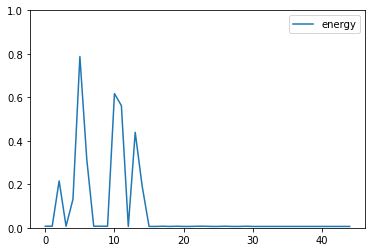

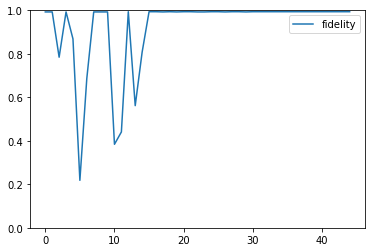

sample 6 case 5
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
Hinfo 199
totoalinput_dim 247


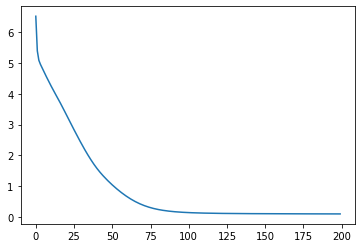

 c_puct 5
movelist-end [12, 30, 48, 68, 88] fail
obs: [ 0.04  0.   -0.04 -0.04 -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
move 12
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
movelist-end [12, 30, 47, 70, 88] fail
obs: [ 0.04  0.   -0.06  0.   -0.04]
movelist-end [12, 30, 48, 68, 93] fail
obs: [ 0.04  0.   -0.04 -0.04  0.06]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
movelist-end [12, 30, 48, 68, 88] fail
obs: [ 0.04  0.   -0.04 -0.04 -0.04]
movelist-end [12, 30, 47, 68, 93] fail
obs: [ 0.04  0.   -0.06 -0.04  0.06]
move 30
movelist-end [12, 30, 49, 70, 93] fail
obs: [ 0.04  0.   -0.02  0.    0.06]
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
movelist-end [12, 30, 48, 68, 88] fail
obs: [ 0.04  0.   -0.04 -0.04 -0.04]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.0

movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 93] fail
obs: [ 0.04  0.   -0.02  0.    0.06]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
move 88
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:5, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 24
kl:1.67863,lr_multiplier:1.000,loss:30.516843795776367,entropy:1.8227386474609375
 c_puct 5
movelist-end [12, 30, 49, 68

kl:2.33139,lr_multiplier:1.000,loss:55.26461410522461,entropy:1.196859359741211
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0. 

kl:0.07972,lr_multiplier:1.000,loss:70.5439224243164,entropy:1.2654576301574707
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0. 

kl:0.01910,lr_multiplier:1.000,loss:74.01390075683594,entropy:1.1254878044128418
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.00914,lr_multiplier:1.000,loss:76.43537139892578,entropy:1.0320391654968262
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.04058,lr_multiplier:1.000,loss:77.28254699707031,entropy:1.103620171546936
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0. 

kl:0.00970,lr_multiplier:1.000,loss:78.65076446533203,entropy:1.0445798635482788
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.02043,lr_multiplier:1.000,loss:79.65532684326172,entropy:0.9645312428474426
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.00450,lr_multiplier:1.000,loss:77.95630645751953,entropy:0.9799684286117554
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:1.61258,lr_multiplier:1.000,loss:80.13058471679688,entropy:0.5699644684791565
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.01005,lr_multiplier:1.000,loss:79.69464111328125,entropy:0.5074617862701416
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.03517,lr_multiplier:1.000,loss:81.83124542236328,entropy:1.4962464570999146
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.00345,lr_multiplier:1.000,loss:81.85832214355469,entropy:1.4799227714538574
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.00432,lr_multiplier:1.000,loss:82.2752914428711,entropy:1.4438610076904297
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0

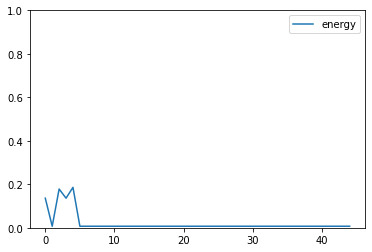

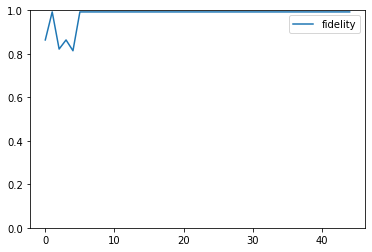

sample 6 case 6
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
Hinfo 199
totoalinput_dim 247


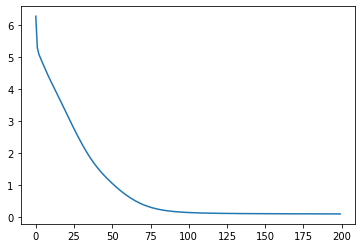

 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -

movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 49
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 68
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
Game end. find eigenstate: 0.007217425247076937 0.99279009035

kl:0.11411,lr_multiplier:1.000,loss:83.67234802246094,entropy:1.4114481210708618
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.01236,lr_multiplier:1.000,loss:83.36772155761719,entropy:1.4503672122955322
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.00972,lr_multiplier:1.000,loss:83.20085144042969,entropy:1.432163119316101
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0. 

kl:0.00576,lr_multiplier:1.000,loss:83.0859603881836,entropy:1.4191540479660034
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0. 

kl:0.00315,lr_multiplier:1.000,loss:83.02202606201172,entropy:1.4151688814163208
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.00678,lr_multiplier:1.000,loss:82.93604278564453,entropy:1.4085781574249268
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.00147,lr_multiplier:1.000,loss:82.8763198852539,entropy:1.406089186668396
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.  

kl:0.00289,lr_multiplier:1.000,loss:82.81961059570312,entropy:1.4039733409881592
 c_puct 5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.

kl:0.00059,lr_multiplier:1.000,loss:82.76788330078125,entropy:1.4001649618148804
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.00138,lr_multiplier:1.000,loss:82.73606872558594,entropy:1.4009379148483276
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.00060,lr_multiplier:1.000,loss:82.69170379638672,entropy:1.398736834526062
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0

kl:0.00262,lr_multiplier:1.000,loss:82.65994262695312,entropy:1.3953875303268433
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

kl:0.00181,lr_multiplier:1.000,loss:82.62698364257812,entropy:1.3970017433166504
 c_puct 0.5
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
move 12
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  0.   -0.02 -0.04  0.  ]
movelist-end [12, 30, 49, 68] win
obs: [ 0.04  

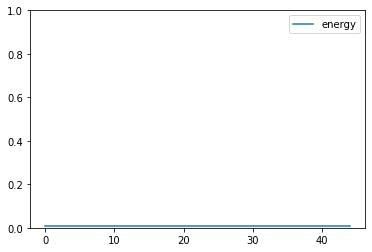

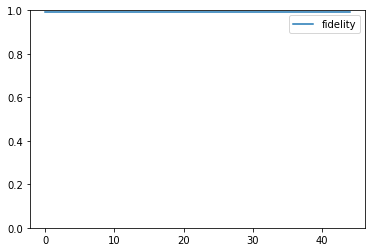

sample 6 case 7
result 56
Hinfo 56
ini 0
nquibit 7 T 70
HP [[6. 0. 0. ... 0. 0. 0.]
 [0. 3. 0. ... 0. 0. 0.]
 [0. 0. 5. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 2. 0. 0.]
 [0. 0. 0. ... 0. 4. 0.]
 [0. 0. 0. ... 0. 0. 2.]]
init_model None
Hinfo 199
totoalinput_dim 247


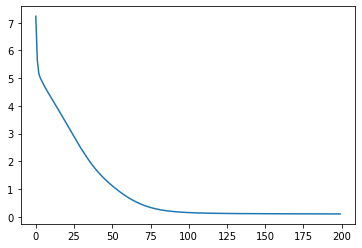

 c_puct 5
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
movelist-end [12, 30, 49, 71, 88] fail
obs: [ 0.04  0.   -0.02  0.02 -0.04]
move 12
movelist-end [12, 30, 48, 65, 88] fail
obs: [ 0.04  0.   -0.04 -0.1  -0.04]
movelist-end [12, 30, 48, 71, 90] fail
obs: [ 0.04  0.   -0.04  0.02  0.  ]
movelist-end [12, 33, 48, 70, 92] fail
obs: [ 0.04  0.06 -0.04  0.    0.04]
movelist-end [12, 33, 47, 70, 92] fail
obs: [ 0.04  0.06 -0.06  0.    0.04]
move 30
movelist-end [12, 30, 49, 71, 90] fail
obs: [ 0.04  0.   -0.02  0.02  0.  ]
movelist-end [12, 30, 48, 68, 88] fail
obs: [ 0.04  0.   -0.04 -0.04 -0.04]
movelist-end [12, 30, 47, 71, 92] fail
obs: [ 0.04  0.   -0.06  0.02  0.04]
movelist-end [12, 30, 48, 69, 90] fail
obs: [ 0.04  0.   -0.04 -0.02  0.  ]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.   -0.02  0.   -0.04]
move 49
movelist-end [12, 30, 49, 65, 88] fail
obs: [ 0.04  0.   -0.02 -0.1  -0.04]
movelist-end [12, 30, 49, 70, 88] fail
obs: [ 0.04  0.

movelist-end [12, 30, 48, 67, 88] fail
obs: [ 0.04  0.   -0.04 -0.06 -0.04]
movelist-end [12, 30, 48, 65, 88] fail
obs: [ 0.04  0.   -0.04 -0.1  -0.04]
movelist-end [12, 30, 48, 71, 88] fail
obs: [ 0.04  0.   -0.04  0.02 -0.04]
movelist-end [12, 30, 48, 68, 88] fail
obs: [ 0.04  0.   -0.04 -0.04 -0.04]
movelist-end [12, 30, 48, 64, 88] fail
obs: [ 0.04  0.   -0.04 -0.12 -0.04]
movelist-end [12, 30, 48, 66, 88] fail
obs: [ 0.04  0.   -0.04 -0.08 -0.04]
move 70
movelist-end [12, 30, 48, 70, 92] fail
obs: [ 0.04  0.   -0.04  0.    0.04]
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
movelist-end [12, 30, 48, 70, 89] fail
obs: [ 0.04  0.   -0.04  0.   -0.02]
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
movelist-end [12, 30, 48, 70, 90] fail
obs: [ 0.04  0.   -0.04  0.    0.  ]
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
movelist-end [12, 30, 48, 70, 88] fail
obs: [ 0.04  0.   -0.04  0.   -0.04]
move

movelist-end [12, 35, 59, 66, 93] fail
obs: [ 0.04  0.1   0.18 -0.08  0.06]
move 88
movelist-end [12, 35, 59, 66, 88] fail
obs: [ 0.04  0.1   0.18 -0.08 -0.04]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:12, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 24
kl:0.24854,lr_multiplier:1.000,loss:29.770414352416992,entropy:3.4679787158966064
 c_puct 5
move 10
move 22
move 50
move 73
movelist-end [10, 22, 50, 73, 88] fail
obs: [ 0.   -0.16  0.    0.06 -0.04]
movelist-end [10, 22, 50, 73, 90] fail
obs: [ 0.   -0.16  0.    0.06  0.  ]
movelist-end [10, 22, 50, 73, 91] fail
obs: [ 0.   -0.16  0.    0.06  0.02]
movelist-end [10, 22, 50, 73, 89] fail
obs: [ 0.   -0.16  0.    0.06 -0.02]
movelist-end [10, 22, 50, 73, 92] fail
obs: [ 0.   -0.16  0.    0.06  0.04]
movelist-end [10, 22, 50, 73, 85] fail
obs: [ 0.   -0.16  0.    0.06 -0.1 ]
movelist-end [10, 22, 50, 73, 95] fail
obs: [ 0.   -0.16  0.    0.06  0.1 ]
movelist-end [10, 22, 50, 73, 93] fail
obs: [ 0.   -0.16  0.    0.06  0

movelist-end [2, 25, 51, 71, 81] fail
obs: [-0.16 -0.1   0.02  0.02 -0.18]
movelist-end [2, 25, 51, 71, 91] fail
obs: [-0.16 -0.1   0.02  0.02  0.02]
movelist-end [2, 25, 51, 71, 96] fail
obs: [-0.16 -0.1   0.02  0.02  0.12]
move 91
movelist-end [2, 25, 51, 71, 91] fail
obs: [-0.16 -0.1   0.02  0.02  0.02]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:20, episode_len:5
~~~~~~~~~~~~~~~~~~~~~~
train_length: 28
kl:0.16683,lr_multiplier:1.000,loss:56.416587829589844,entropy:3.7250277996063232
 c_puct 5
move 15
move 30
move 49
move 79
movelist-end [15, 30, 49, 79, 90] fail
obs: [ 0.1   0.   -0.02  0.18  0.  ]
movelist-end [15, 30, 49, 79, 85] fail
obs: [ 0.1   0.   -0.02  0.18 -0.1 ]
movelist-end [15, 30, 49, 79, 95] fail
obs: [ 0.1   0.   -0.02  0.18  0.1 ]
movelist-end [15, 30, 49, 79, 93] fail
obs: [ 0.1   0.   -0.02  0.18  0.06]
movelist-end [15, 30, 49, 79, 89] fail
obs: [ 0.1   0.   -0.02  0.18 -0.02]
movelist-end [15, 30, 49, 79, 96] fail
obs: [ 0.1   0.   -0.02  0.18  0.12]

kl:0.09594,lr_multiplier:1.000,loss:52.850830078125,entropy:3.79848575592041
 c_puct 5
move 19
move 21
move 58
move 79
movelist-end [19, 21, 58, 79, 88] fail
obs: [ 0.18 -0.18  0.16  0.18 -0.04]
movelist-end [19, 21, 58, 79, 90] fail
obs: [ 0.18 -0.18  0.16  0.18  0.  ]
movelist-end [19, 21, 58, 79, 91] fail
obs: [ 0.18 -0.18  0.16  0.18  0.02]
movelist-end [19, 21, 58, 79, 89] fail
obs: [ 0.18 -0.18  0.16  0.18 -0.02]
movelist-end [19, 21, 58, 79, 92] fail
obs: [ 0.18 -0.18  0.16  0.18  0.04]
movelist-end [19, 21, 58, 79, 81] fail
obs: [ 0.18 -0.18  0.16  0.18 -0.18]
movelist-end [19, 21, 58, 79, 93] fail
obs: [ 0.18 -0.18  0.16  0.18  0.06]
movelist-end [19, 21, 58, 79, 95] fail
obs: [ 0.18 -0.18  0.16  0.18  0.1 ]
movelist-end [19, 21, 58, 79, 85] fail
obs: [ 0.18 -0.18  0.16  0.18 -0.1 ]
movelist-end [19, 21, 58, 79, 96] fail
obs: [ 0.18 -0.18  0.16  0.18  0.12]
move 89
movelist-end [19, 21, 58, 79, 89] fail
obs: [ 0.18 -0.18  0.16  0.18 -0.02]
Game end. Fail
winners_z [-1. -1. -1.

movelist-end [12, 33, 50, 64, 88] fail
obs: [ 0.04  0.06  0.   -0.12 -0.04]
move 68
movelist-end [12, 33, 50, 68, 89] fail
obs: [ 0.04  0.06  0.   -0.04 -0.02]
movelist-end [12, 33, 50, 68, 92] fail
obs: [ 0.04  0.06  0.   -0.04  0.04]
movelist-end [12, 33, 50, 68, 91] fail
obs: [ 0.04  0.06  0.   -0.04  0.02]
movelist-end [12, 33, 50, 68, 81] fail
obs: [ 0.04  0.06  0.   -0.04 -0.18]
movelist-end [12, 33, 50, 68, 85] fail
obs: [ 0.04  0.06  0.   -0.04 -0.1 ]
movelist-end [12, 33, 50, 68, 93] fail
obs: [ 0.04  0.06  0.   -0.04  0.06]
movelist-end [12, 33, 50, 68, 95] fail
obs: [ 0.04  0.06  0.   -0.04  0.1 ]
movelist-end [12, 33, 50, 68, 96] fail
obs: [ 0.04  0.06  0.   -0.04  0.12]
movelist-end [12, 33, 50, 68, 83] fail
obs: [ 0.04  0.06  0.   -0.04 -0.14]
movelist-end [12, 33, 50, 68, 97] fail
obs: [ 0.04  0.06  0.   -0.04  0.14]
move 91
movelist-end [12, 33, 50, 68, 91] fail
obs: [ 0.04  0.06  0.   -0.04  0.02]
Game end. Fail
winners_z [-1. -1. -1. -1. -1.]
batch i:4, episode_len:5


kl:0.16817,lr_multiplier:1.000,loss:60.55711364746094,entropy:3.0850026607513428
 c_puct 0.5
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
move 12
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] wi

kl:0.04689,lr_multiplier:1.000,loss:63.76420593261719,entropy:2.850863218307495
 c_puct 0.5
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
move 12
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win
obs: [ 0.04  0.06 -0.02  0.    0.  ]
movelist-end [12, 33, 49] win

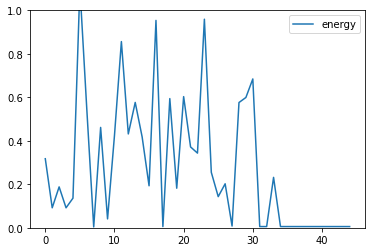

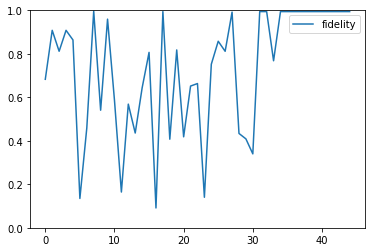

In [22]:
case=1


pptrain=1
exploration=1
game_batch_num=30
sample=6 


lr=0.08
ini=0
runqzero(sample,case,pptrain,exploration,game_batch_num,lr,ini)

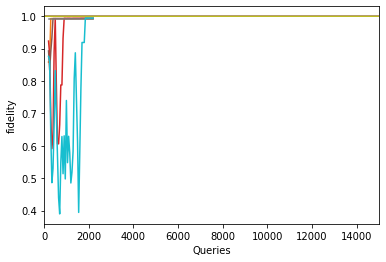

In [29]:
def plote(case):

    y=np.loadtxt('qzerops6c'+str(case)+'fidelity.txt')
    yppo=y.tolist()

    xppo=list(range(len(yppo)))
    
    
    xdata=xppo
    ydata=yppo
    x=[]
    y=[]
    for i in xdata:
        if i>3:
            ymean=np.mean(ydata[int(i)-3:int(i)])
            y.append(ymean)
            x.append(i*50)# from "epsoide" to "queries",  Qzero need to multiply 50=10(n_playout)*5(N_modular)

    plt.plot([1]*15000)
    plt.plot(x, y)   
    plt.xlabel("Queries")
    plt.ylabel("fidelity")
    plt.xlim(0,15000)
    


plote(1)
plote(2)
plote(3)
plote(4)
plote(5)
